In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

Фунции обработки признаков

In [ ]:
def get_holidays():
  #Список праздников в 2021
  holidays = []
  for i in range(1, 11):
    holidays.append(datetime(2021, 1, i).date())
  for i in range(21, 24):
    holidays.append(datetime(2021, 2, i).date())
  for i in range(6, 9):
    holidays.append(datetime(2021, 3, i).date())
  for i in range(1, 4):
    holidays.append(datetime(2021, 5, i).date())
  for i in range(8, 11):
    holidays.append(datetime(2021, 5, i).date())
  for i in range(12, 15):
    holidays.append(datetime(2021, 6, i).date())
  for i in range(4, 8):
    holidays.append(datetime(2021, 11, i).date())
  holidays.append(datetime(2021, 12, 31).date())
  Holidays = np.array([holidays])
  return holidays

In [ ]:
def before_after_holiday(df): 
  df = df.copy()
  holidays = get_holidays()
  #выделим отдельный DataFrame только с датами
  df_dates = pd.Series(df.index, name="date").to_frame().sort_values(by='date')
  df_holidays = pd.DataFrame({'holidays': holidays})
  df_holidays['holidays'] = pd.to_datetime(df_holidays['holidays'])
  df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays', direction='forward')
  df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays')
  df_dates['days_until_holiday'] = df_dates.pop('holidays_x').sub(df_dates['date']).dt.days
  df_dates['days_since_holiday'] = df_dates['date'].sub(df_dates.pop('holidays_y')).dt.days
  df_dates = df_dates.drop_duplicates()
  df = pd.merge(df, df_dates, how='left', on='date')
  if df.index.name != 'date':
    #В DataFrame orders заменим индексы на даты
    df = df.set_index('date')
  #Добавляем строки, чтобы были данные по каждому часу
  df = df.asfreq('H')
  return df

In [ ]:
def create_features(df, id_area=0):
    """
    Create time series features based on time series index.
    """
    holidays = get_holidays()
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.int64)
    df['delivery_area_id'] = id_area
    #Добавляем данные о праздниках (0/1)
    df['Holidays'] = np.array(list(map(lambda x: 1 if x in np.array([holidays]) else 0, df.index.date)))
    #Добавляем отдельно столбец с единицей, если время вне интервала с 10:00 до 20:00
    df['early_late_h'] = np.array(list(map(lambda x: 1 if x in list(range(0, 10))+list(range(21, 24)) else 0,  df.index.hour)))
    #Если выходной, то 1
    df['weekend'] = np.array(list(map(lambda x: 1 if x in [5, 6] else 0, df.index.dayofweek)))
    return df

In [ ]:
def add_lags(df):
  target_map = df['orders_cnt'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('28 days')).map(target_map)
  return df

Функция возвращает pandas DataFrame числа заказов по часам на неделю вперед

In [ ]:
def num_orders_pred(orders_file):
  orders = pd.read_csv(orders_file)
  #преобразуем столбец 'date' в datetime format
  orders['date'] = pd.to_datetime(orders['date'])
  #Собираем уникальные delivery_area_id
  unique_id = orders['delivery_area_id'].unique()

  for id_area in unique_id:
    df = orders[orders['delivery_area_id'] == id_area]
    #В DataFrame orders заменим индекты на даты
    df = df.set_index('date')
    #Добавляем строки, чтобы были данные по каждому часу
    df = df.asfreq('H')
    df['orders_cnt'] = df['orders_cnt'].interpolate()
    df['delivery_area_id'] = id_area
    holidays = get_holidays() #Список праздников в 2021
    df = create_features(df, id_area)
    df = before_after_holiday(df)
    target_map = df['orders_cnt'].to_dict()
    df = add_lags(df)
    #Cross_validation
    pca = StandardScaler()
    tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(df)*.05), gap=24)
    fold = 0
    preds = []
    scores = []

    for train_index, test_index in tscv.split(df):
      train = df.iloc[train_index]
      test = df.iloc[test_index]

      train = create_features(train)
      test = create_features(test)

      FEATURES = ['hour', 'dayofweek', 'quarter',
          'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holidays',
          'early_late_h', 'weekend', 'days_until_holiday', 'days_since_holiday',
          'lag1', 'lag2', 'lag3']
      TARGET = 'orders_cnt'
      X_train = train[FEATURES]
      y_train = train[TARGET]

      X_test = test[FEATURES]
      y_test = test[TARGET]

      # X_train = pca.fit_transform(X_train)
      # X_test = pca.transform(X_test)

      reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                          n_estimators=500,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=3,
                          learning_rate=0.01)
      reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
      y_pred = reg.predict(X_test)
      preds.append(y_pred)
      score = np.sqrt(mean_squared_error(y_test, y_pred))
      scores.append(score)
    #Еще раз обучаемся, но уже на всем датасете
    X_all = df[FEATURES]
    y_all = df[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                            n_estimators=500,
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=3,
                            learning_rate=0.01)
    reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose=100)
    #Create future preds
    print(df.index.max())
    start = (df.index.max() + pd.Timedelta('1h')).to_pydatetime()
    print(start)
    end = (start + pd.Timedelta(8, "d")).to_pydatetime()
    print(end)
    # end =  '2021-12-07 21:00:00'
    future = pd.date_range(start, end, freq='1h')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future.index.name = 'date'
    df_and_future = df_and_future.drop(columns=['days_until_holiday', 'days_since_holiday'])
    df_and_future = before_after_holiday(df_and_future)
    df_and_future = create_features(df_and_future, id_area)
    df_and_future = add_lags(df_and_future)
    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['prediction'] = reg.predict(future_w_features[FEATURES])
    result_part = future_w_features['prediction'].to_frame(name = f'area_id_{id_area}')
    if id_area == 0:
      result = result_part
    else:
      result[f'area_id_{id_area}'] = result_part[f'area_id_{id_area}']
    print(f"Have finished with {id_area}, columns: {result.columns}, len: {len(result)}")
  return result
res = num_orders_pred('orders.csv')

In [ ]:
res_copy = res
res.to_csv('result.csv') #res.to_csv('final_res.csv')

#Файл 'final_res.csv' с посчитанными данными о числе заказов по delivery_area_id c 0 по 592, с 01.12.2021 по 07.12.2021 с 10:00 до 22:00 


In [ ]:
df = pd.read_csv('final_res.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df = df.set_index('date')

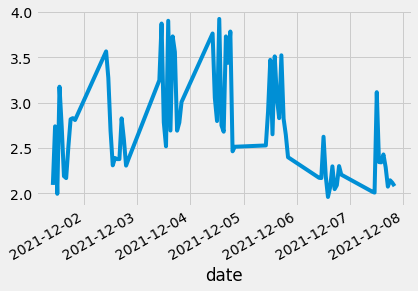

In [ ]:
df['area_id_590'].plot()